In [1]:
%matplotlib inline
import math
from decimal import *
import numpy as np # linear algebra
import pandas as pd # read_csv and such
import matplotlib.pyplot as plt # plotting and such
from geopy.distance import vincenty # calculate distance between locations
from io import StringIO # convert strings to buffers or something like that.
import seaborn as sns

pd.options.display.max_columns = 999

### Get the data and read into a dataframe

In [2]:
# the path to our flight + weather combined data set
flights_weather_path = '../data/flights_weather.csv'

In [3]:
flights_weather_df = pd.read_csv(flights_weather_path)
flights_weather_df.head()

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (8,9,33,34,35,36,51,52,53,70,71,72) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,DATE,IATA_CODE_x,origin_weather_station,IATA_CODE_y,destination_weather_station,OR_TEMP,OR_COUNT_TEMP,OR_DEWP,OR_COUNT_DEWP,OR_SLP,OR_COUNT_SLP,OR_STP,OR_COUNT_STP,OR_VISIB,OR_COUNT_VISIB,OR_WDSP,OR_COUNT_WDSP,OR_MXSPD,OR_GUST,OR_MAX,OR_MIN,OR_PRCP,OR_SNDP,OR_FRSHTT,DES_TEMP,DES_COUNT_TEMP,DES_DEWP,DES_COUNT_DEWP,DES_SLP,DES_COUNT_SLP,DES_STP,DES_COUNT_STP,DES_VISIB,DES_COUNT_VISIB,DES_WDSP,DES_COUNT_WDSP,DES_MXSPD,DES_GUST,DES_MAX,DES_MIN,DES_PRCP,DES_SNDP,DES_FRSHTT
0,0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,21.0,15.0,205.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01,ANC,702725-26491,SEA,727930-24233,35.1,24.0,30.7,24.0,1020.1,14.0,1015.2,24.0,7.5,24.0,3.6,24.0,6.0,999.9,43.0,32.0,0.09G,999.9,110000.0,32.9,24.0,22.2,24.0,1029.7,24.0,1012.7,24.0,10.0,24.0,4.6,24.0,11.1,999.9,42.1,26.1,0.00G,999.9,0.0
1,1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,-8.0,12.0,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01,LAX,722950-23174,PBI,722030-12844,47.1,24.0,22.5,24.0,1018.8,24.0,1007.2,24.0,10.0,24.0,5.5,24.0,15.0,999.9,57.0,36.0,0.00G,999.9,0.0,74.1,24.0,69.7,24.0,1021.1,22.0,1020.5,24.0,9.1,24.0,5.5,24.0,9.9,999.9,79.0,70.0,0.33G,999.9,10000.0
2,2,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.0,-2.0,16.0,34.0,286.0,293.0,266.0,2296,800.0,11.0,806,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01,SFO,724940-23234,CLT,723140-13881,49.5,24.0,30.9,24.0,1019.4,24.0,1018.8,24.0,10.0,24.0,7.8,24.0,15.0,999.9,57.9,39.9,0.00G,999.9,0.0,38.4,24.0,28.4,24.0,1026.8,24.0,998.5,24.0,9.7,24.0,2.3,24.0,7.0,999.9,53.1,26.1,0.00G,999.9,0.0
3,3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,-5.0,15.0,30.0,285.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01,LAX,722950-23174,MIA,722020-12839,47.1,24.0,22.5,24.0,1018.8,24.0,1007.2,24.0,10.0,24.0,5.5,24.0,15.0,999.9,57.0,36.0,0.00G,999.9,0.0,74.8,24.0,67.8,24.0,1021.3,24.0,1020.2,24.0,8.9,24.0,4.1,24.0,11.1,999.9,82.0,70.0,0.00G,999.9,0.0
4,4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,-1.0,11.0,35.0,235.0,215.0,199.0,1448,254.0,5.0,320,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01,SEA,727930-24233,ANC,702725-26491,32.9,24.0,22.2,24.0,1029.7,24.0,1012.7,24.0,10.0,24.0,4.6,24.0,11.1,999.9,42.1,26.1,0.00G,999.9,0.0,35.1,24.0,30.7,24.0,1020.1,14.0,1015.2,24.0,7.5,24.0,3.6,24.0,6.0,999.9,43.0,32.0,0.09G,999.9,110000.0


In [4]:
# Drop the first column that has unneeded indexes
flights_weather_df = flights_weather_df.drop(flights_weather_df.columns[0], axis=1)
flights_weather_df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,DATE,IATA_CODE_x,origin_weather_station,IATA_CODE_y,destination_weather_station,OR_TEMP,OR_COUNT_TEMP,OR_DEWP,OR_COUNT_DEWP,OR_SLP,OR_COUNT_SLP,OR_STP,OR_COUNT_STP,OR_VISIB,OR_COUNT_VISIB,OR_WDSP,OR_COUNT_WDSP,OR_MXSPD,OR_GUST,OR_MAX,OR_MIN,OR_PRCP,OR_SNDP,OR_FRSHTT,DES_TEMP,DES_COUNT_TEMP,DES_DEWP,DES_COUNT_DEWP,DES_SLP,DES_COUNT_SLP,DES_STP,DES_COUNT_STP,DES_VISIB,DES_COUNT_VISIB,DES_WDSP,DES_COUNT_WDSP,DES_MXSPD,DES_GUST,DES_MAX,DES_MIN,DES_PRCP,DES_SNDP,DES_FRSHTT
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,21.0,15.0,205.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01,ANC,702725-26491,SEA,727930-24233,35.1,24.0,30.7,24.0,1020.1,14.0,1015.2,24.0,7.5,24.0,3.6,24.0,6.0,999.9,43.0,32.0,0.09G,999.9,110000.0,32.9,24.0,22.2,24.0,1029.7,24.0,1012.7,24.0,10.0,24.0,4.6,24.0,11.1,999.9,42.1,26.1,0.00G,999.9,0.0
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,-8.0,12.0,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01,LAX,722950-23174,PBI,722030-12844,47.1,24.0,22.5,24.0,1018.8,24.0,1007.2,24.0,10.0,24.0,5.5,24.0,15.0,999.9,57.0,36.0,0.00G,999.9,0.0,74.1,24.0,69.7,24.0,1021.1,22.0,1020.5,24.0,9.1,24.0,5.5,24.0,9.9,999.9,79.0,70.0,0.33G,999.9,10000.0
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.0,-2.0,16.0,34.0,286.0,293.0,266.0,2296,800.0,11.0,806,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01,SFO,724940-23234,CLT,723140-13881,49.5,24.0,30.9,24.0,1019.4,24.0,1018.8,24.0,10.0,24.0,7.8,24.0,15.0,999.9,57.9,39.9,0.00G,999.9,0.0,38.4,24.0,28.4,24.0,1026.8,24.0,998.5,24.0,9.7,24.0,2.3,24.0,7.0,999.9,53.1,26.1,0.00G,999.9,0.0
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,-5.0,15.0,30.0,285.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01,LAX,722950-23174,MIA,722020-12839,47.1,24.0,22.5,24.0,1018.8,24.0,1007.2,24.0,10.0,24.0,5.5,24.0,15.0,999.9,57.0,36.0,0.00G,999.9,0.0,74.8,24.0,67.8,24.0,1021.3,24.0,1020.2,24.0,8.9,24.0,4.1,24.0,11.1,999.9,82.0,70.0,0.00G,999.9,0.0
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,-1.0,11.0,35.0,235.0,215.0,199.0,1448,254.0,5.0,320,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01,SEA,727930-24233,ANC,702725-26491,32.9,24.0,22.2,24.0,1029.7,24.0,1012.7,24.0,10.0,24.0,4.6,24.0,11.1,999.9,42.1,26.1,0.00G,999.9,0.0,35.1,24.0,30.7,24.0,1020.1,14.0,1015.2,24.0,7.5,24.0,3.6,24.0,6.0,999.9,43.0,32.0,0.09G,999.9,110000.0


## Clean Up Weather Columns

Remove all weather columns related to COUNT. These values only specify a number of observations made and will not be correlative with the flight delays

In [5]:
# Drop the COUNT-related weather columns that only specify the number of observations (not correlated to delays) 
flights_weather_df = flights_weather_df.drop(['OR_COUNT_TEMP', 'OR_COUNT_DEWP', 'OR_COUNT_SLP', 'OR_COUNT_STP', 'OR_COUNT_VISIB', 'OR_COUNT_WDSP'], 1)
flights_weather_df = flights_weather_df.drop(['DES_COUNT_TEMP', 'DES_COUNT_DEWP', 'DES_COUNT_SLP', 'DES_COUNT_STP', 'DES_COUNT_VISIB', 'DES_COUNT_WDSP'], 1)
flights_weather_df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,DATE,IATA_CODE_x,origin_weather_station,IATA_CODE_y,destination_weather_station,OR_TEMP,OR_DEWP,OR_SLP,OR_STP,OR_VISIB,OR_WDSP,OR_MXSPD,OR_GUST,OR_MAX,OR_MIN,OR_PRCP,OR_SNDP,OR_FRSHTT,DES_TEMP,DES_DEWP,DES_SLP,DES_STP,DES_VISIB,DES_WDSP,DES_MXSPD,DES_GUST,DES_MAX,DES_MIN,DES_PRCP,DES_SNDP,DES_FRSHTT
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,21.0,15.0,205.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01,ANC,702725-26491,SEA,727930-24233,35.1,30.7,1020.1,1015.2,7.5,3.6,6.0,999.9,43.0,32.0,0.09G,999.9,110000.0,32.9,22.2,1029.7,1012.7,10.0,4.6,11.1,999.9,42.1,26.1,0.00G,999.9,0.0
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,-8.0,12.0,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01,LAX,722950-23174,PBI,722030-12844,47.1,22.5,1018.8,1007.2,10.0,5.5,15.0,999.9,57.0,36.0,0.00G,999.9,0.0,74.1,69.7,1021.1,1020.5,9.1,5.5,9.9,999.9,79.0,70.0,0.33G,999.9,10000.0
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.0,-2.0,16.0,34.0,286.0,293.0,266.0,2296,800.0,11.0,806,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01,SFO,724940-23234,CLT,723140-13881,49.5,30.9,1019.4,1018.8,10.0,7.8,15.0,999.9,57.9,39.9,0.00G,999.9,0.0,38.4,28.4,1026.8,998.5,9.7,2.3,7.0,999.9,53.1,26.1,0.00G,999.9,0.0
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,-5.0,15.0,30.0,285.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01,LAX,722950-23174,MIA,722020-12839,47.1,22.5,1018.8,1007.2,10.0,5.5,15.0,999.9,57.0,36.0,0.00G,999.9,0.0,74.8,67.8,1021.3,1020.2,8.9,4.1,11.1,999.9,82.0,70.0,0.00G,999.9,0.0
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,-1.0,11.0,35.0,235.0,215.0,199.0,1448,254.0,5.0,320,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2015-01-01,SEA,727930-24233,ANC,702725-26491,32.9,22.2,1029.7,1012.7,10.0,4.6,11.1,999.9,42.1,26.1,0.00G,999.9,0.0,35.1,30.7,1020.1,1015.2,7.5,3.6,6.0,999.9,43.0,32.0,0.09G,999.9,110000.0


## Clean Up Flight Columns

For this analysis, we don't need some of the flight data that won't have any correlative significance with the weather (eg. flight number, tail number, etc.). Remove all of these unneeded columns

In [6]:
flights_weather_df = flights_weather_df.drop(['FLIGHT_NUMBER', 'TAIL_NUMBER', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY'], axis=1)
flights_weather_df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DATE,IATA_CODE_x,origin_weather_station,IATA_CODE_y,destination_weather_station,OR_TEMP,OR_DEWP,OR_SLP,OR_STP,OR_VISIB,OR_WDSP,OR_MXSPD,OR_GUST,OR_MAX,OR_MIN,OR_PRCP,OR_SNDP,OR_FRSHTT,DES_TEMP,DES_DEWP,DES_SLP,DES_STP,DES_VISIB,DES_WDSP,DES_MXSPD,DES_GUST,DES_MAX,DES_MIN,DES_PRCP,DES_SNDP,DES_FRSHTT
0,2015,1,1,4,AS,ANC,SEA,5,2354.0,-11.0,21.0,15.0,205.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0,2015-01-01,ANC,702725-26491,SEA,727930-24233,35.1,30.7,1020.1,1015.2,7.5,3.6,6.0,999.9,43.0,32.0,0.09G,999.9,110000.0,32.9,22.2,1029.7,1012.7,10.0,4.6,11.1,999.9,42.1,26.1,0.00G,999.9,0.0
1,2015,1,1,4,AA,LAX,PBI,10,2.0,-8.0,12.0,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,2015-01-01,LAX,722950-23174,PBI,722030-12844,47.1,22.5,1018.8,1007.2,10.0,5.5,15.0,999.9,57.0,36.0,0.00G,999.9,0.0,74.1,69.7,1021.1,1020.5,9.1,5.5,9.9,999.9,79.0,70.0,0.33G,999.9,10000.0
2,2015,1,1,4,US,SFO,CLT,20,18.0,-2.0,16.0,34.0,286.0,293.0,266.0,2296,800.0,11.0,806,811.0,5.0,2015-01-01,SFO,724940-23234,CLT,723140-13881,49.5,30.9,1019.4,1018.8,10.0,7.8,15.0,999.9,57.9,39.9,0.00G,999.9,0.0,38.4,28.4,1026.8,998.5,9.7,2.3,7.0,999.9,53.1,26.1,0.00G,999.9,0.0
3,2015,1,1,4,AA,LAX,MIA,20,15.0,-5.0,15.0,30.0,285.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0,2015-01-01,LAX,722950-23174,MIA,722020-12839,47.1,22.5,1018.8,1007.2,10.0,5.5,15.0,999.9,57.0,36.0,0.00G,999.9,0.0,74.8,67.8,1021.3,1020.2,8.9,4.1,11.1,999.9,82.0,70.0,0.00G,999.9,0.0
4,2015,1,1,4,AS,SEA,ANC,25,24.0,-1.0,11.0,35.0,235.0,215.0,199.0,1448,254.0,5.0,320,259.0,-21.0,2015-01-01,SEA,727930-24233,ANC,702725-26491,32.9,22.2,1029.7,1012.7,10.0,4.6,11.1,999.9,42.1,26.1,0.00G,999.9,0.0,35.1,30.7,1020.1,1015.2,7.5,3.6,6.0,999.9,43.0,32.0,0.09G,999.9,110000.0


### Clean up miscellaneous columns that are descriptive and non-numeric (won't be correlative)

In [7]:
flights_weather_df = flights_weather_df.drop(['YEAR', 'AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'DATE', 'IATA_CODE_x', 'origin_weather_station', 'IATA_CODE_y', 'destination_weather_station'], axis=1)
flights_weather_df.head()

,MONTH,DAY,DAY_OF_WEEK,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,OR_TEMP,OR_DEWP,OR_SLP,OR_STP,OR_VISIB,OR_WDSP,OR_MXSPD,OR_GUST,OR_MAX,OR_MIN,OR_PRCP,OR_SNDP,OR_FRSHTT,DES_TEMP,DES_DEWP,DES_SLP,DES_STP,DES_VISIB,DES_WDSP,DES_MXSPD,DES_GUST,DES_MAX,DES_MIN,DES_PRCP,DES_SNDP,DES_FRSHTT
0,1,1,4,5,2354.0,-11.0,21.0,15.0,205.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0,35.1,30.7,1020.1,1015.2,7.5,3.6,6.0,999.9,43.0,32.0,0.09G,999.9,110000.0,32.9,22.2,1029.7,1012.7,10.0,4.6,11.1,999.9,42.1,26.1,0.00G,999.9,0.0
1,1,1,4,10,2.0,-8.0,12.0,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,47.1,22.5,1018.8,1007.2,10.0,5.5,15.0,999.9,57.0,36.0,0.00G,999.9,0.0,74.1,69.7,1021.1,1020.5,9.1,5.5,9.9,999.9,79.0,70.0,0.33G,999.9,10000.0
2,1,1,4,20,18.0,-2.0,16.0,34.0,286.0,293.0,266.0,2296,800.0,11.0,806,811.0,5.0,49.5,30.9,1019.4,1018.8,10.0,7.8,15.0,999.9,57.9,39.9,0.00G,999.9,0.0,38.4,28.4,1026.8,998.5,9.7,2.3,7.0,999.9,53.1,26.1,0.00G,999.9,0.0
3,1,1,4,20,15.0,-5.0,15.0,30.0,285.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0,47.1,22.5,1018.8,1007.2,10.0,5.5,15.0,999.9,57.0,36.0,0.00G,999.9,0.0,74.8,67.8,1021.3,1020.2,8.9,4.1,11.1,999.9,82.0,70.0,0.00G,999.9,0.0
4,1,1,4,25,24.0,-1.0,11.0,35.0,235.0,215.0,199.0,1448,254.0,5.0,320,259.0,-21.0,32.9,22.2,1029.7,1012.7,10.0,4.6,11.1,999.9,42.1,26.1,0.00G,999.9,0.0,35.1,30.7,1020.1,1015.2,7.5,3.6,6.0,999.9,43.0,32.0,0.09G,999.9,110000.0


# Correlation Analysis of 2015 Flight Delays and Weather Data
---
We want to do a simple correlation analysis of the combined flight + weather dataset, and produce a heatmap of the variable correlaitons.

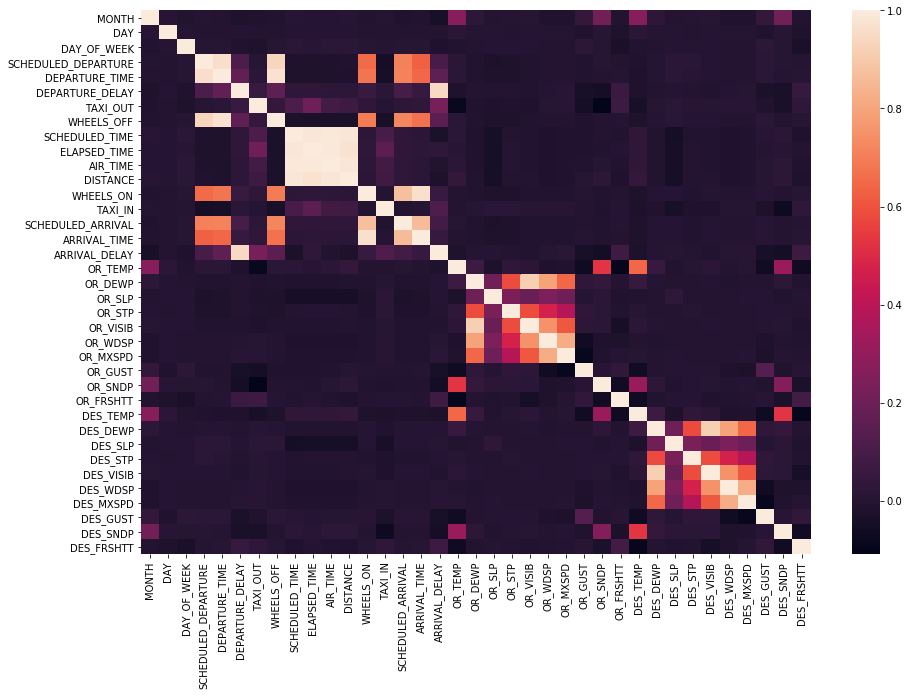

In [8]:
corr = flights_weather_df.corr()
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, ax=ax)

# Correlation in Numbers

### Correlation Matrix

In [9]:
corr

,MONTH,DAY,DAY_OF_WEEK,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,OR_TEMP,OR_DEWP,OR_SLP,OR_STP,OR_VISIB,OR_WDSP,OR_MXSPD,OR_GUST,OR_SNDP,OR_FRSHTT,DES_TEMP,DES_DEWP,DES_SLP,DES_STP,DES_VISIB,DES_WDSP,DES_MXSPD,DES_GUST,DES_SNDP,DES_FRSHTT
MONTH,1.000000,0.008874,-0.007847,0.000207,-0.004085,-0.021994,-0.013117,-0.004946,0.010784,0.001871,0.003379,0.011437,-0.008917,0.002095,-0.010121,-0.009133,-0.036793,0.266299,0.022474,-0.002923,0.003512,0.004034,-0.009858,-0.012635,0.039972,0.208562,-0.005651,0.266336,0.022473,-0.002937,0.003547,0.004021,-0.009885,-0.012632,0.039996,0.208569,-0.005534
DAY,0.008874,1.000000,0.001111,-0.001647,-0.002644,-0.000176,-0.002661,-0.003318,0.003403,0.001419,0.001923,0.003529,-0.004294,-0.001656,-0.003688,-0.004310,-0.003097,0.020874,0.000746,-0.000419,-0.001375,0.003175,0.002414,0.001715,-0.009323,0.011703,-0.021390,0.021017,0.000766,-0.000479,-0.001381,0.003178,0.002399,0.001710,-0.009290,0.011761,-0.021510
DAY_OF_WEEK,-0.007847,0.001111,1.000000,0.008007,0.005607,-0.011510,-0.020639,0.004060,0.014954,0.011510,0.014284,0.016516,0.005642,0.001111,0.007092,0.005641,-0.017027,-0.005663,-0.002317,0.003114,0.001437,0.001278,-0.002258,-0.002503,0.022912,0.007210,-0.031691,-0.005748,-0.002306,0.003239,0.001827,0.001289,-0.002263,-0.002543,0.022946,0.007176,-0.031705
SCHEDULED_DEPARTURE,0.000207,-0.001647,0.008007,1.000000,0.963791,0.110149,0.006581,0.938008,-0.016609,-0.017935,-0.015756,-0.009572,0.656098,-0.044719,0.706237,0.629342,0.100220,0.020918,-0.006676,-0.022956,-0.019479,-0.007503,-0.002613,-0.003269,-0.006973,0.004174,-0.003870,-0.012345,0.002775,0.017745,0.014736,0.003710,-0.003236,-0.002792,0.014230,0.004893,0.001240
DEPARTURE_TIME,-0.004085,-0.002644,0.005607,0.963791,1.000000,0.171723,0.014002,0.971971,-0.020851,-0.021990,-0.021146,-0.016492,0.675882,-0.040613,0.710223,0.648265,0.159787,0.016132,-0.006921,-0.022073,-0.018719,-0.008178,-0.002543,-0.002980,-0.008815,-0.001293,0.002063,-0.016989,0.001968,0.014485,0.008273,0.002839,-0.003134,-0.002324,0.013259,0.000368,0.005511
DEPARTURE_DELAY,-0.021994,-0.000176,-0.011510,0.110149,0.171723,1.000000,0.058515,0.162582,0.027799,0.030805,0.023495,0.024106,0.058674,0.012784,0.097566,0.049236,0.944672,-0.015897,-0.002190,-0.003120,-0.002586,-0.007267,0.001792,0.008711,-0.035365,-0.047624,0.062606,-0.014506,-0.001804,-0.000389,-0.000618,-0.006233,0.001950,0.007033,-0.026606,-0.034039,0.050092
TAXI_OUT,-0.013117,-0.002661,-0.020639,0.006581,0.014002,0.058515,1.000000,0.039104,0.112302,0.205195,0.087608,0.072333,0.032584,0.003221,0.024384,0.029745,0.227319,-0.084775,-0.010643,-0.017045,-0.011685,-0.014120,0.006722,0.010152,-0.047279,-0.108893,0.070765,-0.035677,0.007318,0.013484,0.009404,0.006094,0.010160,0.010151,-0.013027,-0.032990,0.027338
WHEELS_OFF,-0.004946,-0.003318,0.004060,0.938008,0.971971,0.162582,0.039104,1.000000,-0.028289,-0.027133,-0.029654,-0.027586,0.695734,-0.038814,0.721877,0.667991,0.155773,0.013426,-0.006918,-0.021621,-0.018063,-0.008334,-0.001981,-0.002695,-0.010480,-0.004497,0.003635,-0.019249,0.002184,0.012791,0.003493,0.003230,-0.002760,-0.002010,0.013819,-0.000678,0.005759
SCHEDULED_TIME,0.010784,0.003403,0.014954,-0.016609,-0.020851,0.027799,0.112302,-0.028289,1.000000,0.985260,0.990749,0.984336,0.023414,0.099036,0.031963,0.020439,-0.030029,0.013244,-0.011194,-0.043591,-0.000927,-0.009194,-0.015431,-0.012297,-0.009754,-0.001705,-0.008728,0.033994,-0.008510,-0.044853,-0.005574,-0.006224,-0.017826,-0.012938,0.009612,0.020576,-0.016572
ELAPSED_TIME,0.001871,0.001419,0.011510,-0.017935,-0.021990,0.030805,0.205195,-0.027133,0.985260,1.000000,0.990033,0.973696,0.025644,0.156179,0.031246,0.022579,0.029120,0.008490,-0.010240,-0.041640,-0.000178,-0.009196,-0.013796,-0.009414,-0.012344,-0.008282,0.003063,0.026142,-0.007638,-0.043137,-0.004303,-0.006196,-0.015298,-0.009549,0.001418,0.011471,-0.004295


## Which correlations are the most significant?

Print out a sorted list of the correlation pairs so we can see which ones are the most significant. As you see below, many of the correlations at the top are somewhat obvious (e.g. ELAPSED_TIME v. DISTANCE = 0.9736 is to be expected - the further you're traveling the longer it will take).

Now, we can start to focus on the correlations between weather and flight data, specifically. They are further down the list, but may still have some statitical significance. Will need to look into what range of correlation values are considered statistically significant. For example, ARRIVAL_DELAY vs. OR_FRSHTT = 0.0768. Is this signi

In [10]:
pd.options.display.max_rows = 9999

corr_abs = flights_weather_df.corr().abs().unstack()
corr_abs = corr_abs.sort_values(ascending=False)


print corr_abs[corr_abs != 1.0]

AIR_TIME             SCHEDULED_TIME         0.990749
SCHEDULED_TIME       AIR_TIME               0.990749
AIR_TIME             ELAPSED_TIME           0.990033
ELAPSED_TIME         AIR_TIME               0.990033
DISTANCE             AIR_TIME               0.985643
AIR_TIME             DISTANCE               0.985643
ELAPSED_TIME         SCHEDULED_TIME         0.985260
SCHEDULED_TIME       ELAPSED_TIME           0.985260
DISTANCE             SCHEDULED_TIME         0.984336
SCHEDULED_TIME       DISTANCE               0.984336
DISTANCE             ELAPSED_TIME           0.973696
ELAPSED_TIME         DISTANCE               0.973696
DEPARTURE_TIME       WHEELS_OFF             0.971971
WHEELS_OFF           DEPARTURE_TIME         0.971971
ARRIVAL_TIME         WHEELS_ON              0.968035
WHEELS_ON            ARRIVAL_TIME           0.968035
DEPARTURE_TIME       SCHEDULED_DEPARTURE    0.963791
SCHEDULED_DEPARTURE  DEPARTURE_TIME         0.963791
ARRIVAL_DELAY        DEPARTURE_DELAY        0.